### AI Project #4: Working with sklearn 
Classifiers and Regressors: Decision Tree, KNeighbors, Logistic Regression <br>
Ensemble: Bagging, Random Forest, Voting <br>

Mahsa Eskandari Ghadi         
Student No. 810196597

In this project, we're looking at some Machine Learning methods with the help of SciKit-Learn Library. The project consists of 3 Parts, Part0: looking at the dataset, Part1: modeling with classifiers and optimizing them, Part2: Ensemble methods and analyzing the results.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
#!pip install -U imbalanced-learn
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
def make_predictions (clf, accuracy_train, accuracy_test) :
    
    clf.fit(X_train, y_train)

    pred_test = clf.predict(X_test)
    accuracy_test.append(accuracy_score(y_true=y_test, y_pred=pred_test))

    pred_train = clf.predict(X_train)
    accuracy_train.append(accuracy_score(y_true=y_train, y_pred=pred_train))
    
    return accuracy_train, accuracy_test

In [164]:
def plot_param_vs_acc (param, accuracy_train, accuracy_test, param_name) :

    acc_fig = plt.figure()
    ax = acc_fig.add_axes([0,0,1,1])
    ax.plot(param, accuracy_train, label="train", color='#FDEDEC', linewidth=5)
    ax.plot(param, accuracy_test, label='test', color='#D4E6F1', linewidth=5)
    ax.legend()
    ax.set_title('Accuracy vs. {}'.format(param_name))
    ax.set_xlabel(param_name)
    ax.set_ylabel('accuracy')

### <font color="9AC0CD"><b> Part 0: The Dataset </b></font>
The data of our project is a store record of customers with helpful details and the fact that they've came back for more purchases or not. Our goal is to construct a model that will determine whether the customer will come back or not with a reasonable accuracy.

In [202]:
df = pd.read_csv("data.csv")
df.head()

,Unnamed: 0,Customer ID,Total Quantity,Total Price,Country,Date,Is Back,Purchase Count
0,0,16995,-1,-1.25,United Kingdom,2010-12-02,No,1
1,1,12552,85,13.52,Italy,2011-10-31,Yes,19
2,2,13192,298,15.90,United Kingdom,2011-05-18,Yes,33
3,3,16934,399,8.30,United Kingdom,2011-10-16,No,62
4,4,14976,27,11.90,United Kingdom,2011-01-17,Yes,16


Looking at the data we see that we have 2 main problems. First, a categorical column(Country) needs to be converted into numerical so that our models can work with them. Second, there's a date column that's not really usable this way and it has to be converted into actual dates. Using a LabelEncoder we can fix the first problem. LabelEncoder assigns a specific number to each country. Getting help from pandas we can convert the dates in the Date column to actual usefull dates and get the year, month and day of each. Depending on the nature of the problem it sounds reasonable to have a "Day of the Week" column since people go shopping on the weekends more often than working days.

In [203]:
data = df.drop(columns=['Unnamed: 0', 'Customer ID'])

le = LabelEncoder()
data['Is Back'] = le.fit_transform(data['Is Back'])

data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Day of Week'] = data['Date'].dt.dayofweek

data.head()

,Total Quantity,Total Price,Country,Date,Is Back,Purchase Count,Year,Month,Day,Day of Week
0,-1,-1.25,United Kingdom,2010-12-02,0,1,2010,12,2,3
1,85,13.52,Italy,2011-10-31,1,19,2011,10,31,0
2,298,15.90,United Kingdom,2011-05-18,1,33,2011,5,18,2
3,399,8.30,United Kingdom,2011-10-16,0,62,2011,10,16,6
4,27,11.90,United Kingdom,2011-01-17,1,16,2011,1,17,0


In [204]:
clean_data = data.drop(columns=['Date'])
clean_data.head()

,Total Quantity,Total Price,Country,Is Back,Purchase Count,Year,Month,Day,Day of Week
0,-1,-1.25,United Kingdom,0,1,2010,12,2,3
1,85,13.52,Italy,1,19,2011,10,31,0
2,298,15.90,United Kingdom,1,33,2011,5,18,2
3,399,8.30,United Kingdom,0,62,2011,10,16,6
4,27,11.90,United Kingdom,1,16,2011,1,17,0


After cleaning the data, we have to decide what we want to guess with our model(target) and what we want to use to guess the target(features).

In [168]:
# split dataset in features and target variable
X = clean_data.drop(columns=['Is Back'])  # Features
y = clean_data['Is Back']  # Target variable

In [170]:
X['Country'] = le.fit_transform(X['Country'])
X.head()

,Total Quantity,Total Price,Country,Purchase Count,Year,Month,Day,Day of Week
0,-1,-1.25,35,1,2010,12,2,3
1,85,13.52,18,19,2011,10,31,0
2,298,15.90,35,33,2011,5,18,2
3,399,8.30,35,62,2011,10,16,6
4,27,11.90,35,16,2011,1,17,0


Usually in the real world when classifying some data, you have more from one class to train your data one which doesn't seem fair to know more about one class and less about other ones, you can balane the training data with a RandomOverSampler or you can leave it alone and let nature do it's thing. Here since I got better results without oversampling I commented it out.

In [171]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=101)
# X_resampled, y_resampled = ros.fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))
# print()
# print(X_resampled.tail())

# # from imblearn.over_sampling import SMOTE
# # sm = SMOTE(random_state =101)
# # X_resampled, y_resampled = sm.fit_sample(X, y.ravel())
# # print(sorted(Counter(y_resampled).items()))
# # print()
# # print(X_resampled.tail())

Plotting the Information Gain can be helpful since it's the reduction in entropy or surprise by transforming a dataset which basically means that it shows how much a feature can help the model get closer to finding out the target.

In [139]:
from sklearn.feature_selection import mutual_info_classif

Text(0, 0.5, 'Gain')

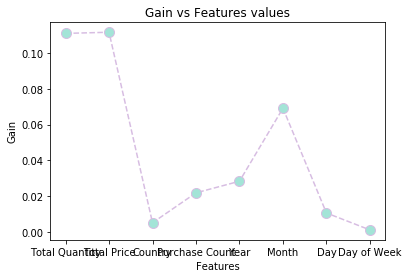

In [172]:
mic = mutual_info_classif(X, y, discrete_features=True)
plt.plot(X.columns, mic, color='#D7BDE2', linestyle='dashed', marker='o', markerfacecolor='#A3E4D7', markersize=10)
plt.title('Gain vs Features values')
plt.xlabel('Features')
plt.ylabel('Gain')

The plot above depicts that Total Quantity and Total Price are the features that help us best in choosing a class and after that Month is the best feature which makes sense because for instance people usually don't go back to a store after shopping for Christmas until the end of the holidays. 

### <font color="9AC0CD"><b> Part 1: Classifiers </b></font>

####  <font color="D7BDE2"><b> 1.1: Decision Tree</b></font>

like any other classifying problems we have to split the data into these four dataframes.

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=101) 

To get better precision and recall it is nice to prune the tree and only use the nodes that are actually usefull. In DecisionTreeClassifier, pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides <font color="9AC0CD"><b>DecisionTreeClassifier.cost_complexity_pruning_path </b></font> that returns the<font color="9AC0CD"><b> effective alphas </b></font> and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.[1]

In [177]:
clf = DecisionTreeClassifier(random_state=101, criterion='entropy')
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node. we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. [1]

In [155]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [156]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and 60% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. Here, setting anything after ccp_alpha=0.002 maximizes the testing accuracy. [1]

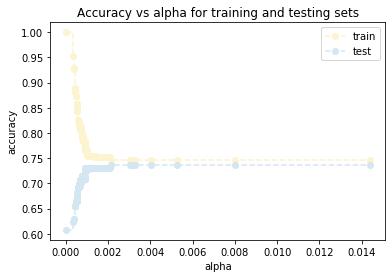

In [157]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, label="train", drawstyle="steps-post", color='#FCF3CF', linestyle="dashed", marker='o')
ax.plot(ccp_alphas, test_scores, label="test", drawstyle="steps-post", color='#D4E6F1', linestyle="dashed", marker='o')
ax.legend()
plt.show()

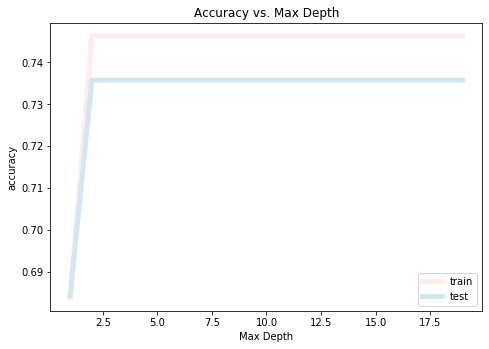

In [158]:
error_rate = []

accuracy_test = []
accuracy_train = []

depths = range(1, 20)

for depth in depths:

    dtree = DecisionTreeClassifier(max_depth=depth, random_state=101, ccp_alpha=0.0023)
    accuracy_train, accuracy_test = make_predictions(dtree, accuracy_train, accuracy_test)

plot_param_vs_acc(depths, accuracy_train, accuracy_test, "Max Depth")

As we can see after a little less than 2.5 the tree overfits, with less than 75% training accuracy and less than 74% testing accuracy which is not really that much of overfitting.<br>
Now that we know the best alpha and max_depth to use we model the Decision Tree.

In [178]:
dtree = DecisionTreeClassifier(max_depth = 3, ccp_alpha=0.0023, criterion='entropy')
dtree.fit(X_train, y_train)
y_pred_test = dtree.predict(X_test)
y_pred_train = dtree.predict(X_train)
print(confusion_matrix(y_test, y_pred_test))
print()
print('Precision: ', precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted'))
print('Recall: ', recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted'))
print()
print('Train Accuracy: ', accuracy_score(y_true=y_train, y_pred=y_pred_train))
print('Test Accuracy: ', accuracy_score(y_true=y_test, y_pred=y_pred_test))

[[ 90 186]
 [ 45 553]]

Precision:  0.7225268855494622
Recall:  0.7356979405034325

Train Accuracy:  0.7462772050400917
Test Accuracy:  0.7356979405034325


The average Precision and Recall are looking good enough and the train-test accuracies show almost zero overfitting. Down here we plot the tree to have a better understanding of what's actually happening and with what features the tree is spliting.

In [74]:
from sklearn.tree import plot_tree

In [179]:
classes = list(y.unique())
features = list(X.columns)
features

['Total Quantity',
 'Total Price',
 'Country',
 'Purchase Count',
 'Year',
 'Month',
 'Day',
 'Day of Week']

[Text(136.96363636363637, 190.26, 'Year <= -0.751\nentropy = 0.906\nsamples = 3349\nvalue = [1076, 2273]'),
 Text(60.872727272727275, 135.9, 'Total Quantity <= -0.361\nentropy = 0.504\nsamples = 665\nvalue = [74, 591]'),
 Text(30.436363636363637, 81.53999999999999, 'entropy = 0.662\nsamples = 227\nvalue = [39, 188]'),
 Text(91.30909090909091, 81.53999999999999, 'entropy = 0.402\nsamples = 438\nvalue = [35, 403]'),
 Text(213.05454545454546, 135.9, 'Month <= 0.639\nentropy = 0.953\nsamples = 2684\nvalue = [1002, 1682]'),
 Text(152.1818181818182, 81.53999999999999, 'Month <= -1.128\nentropy = 0.87\nsamples = 2112\nvalue = [614, 1498]'),
 Text(121.74545454545455, 27.180000000000007, 'entropy = 0.694\nsamples = 606\nvalue = [113, 493]'),
 Text(182.61818181818182, 27.180000000000007, 'entropy = 0.918\nsamples = 1506\nvalue = [501, 1005]'),
 Text(273.92727272727274, 81.53999999999999, 'Month <= 1.144\nentropy = 0.906\nsamples = 572\nvalue = [388, 184]'),
 Text(243.4909090909091, 27.1800000000

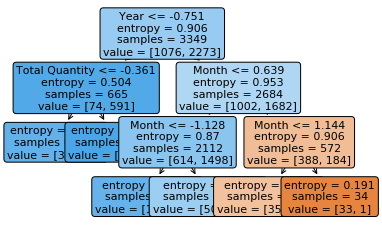

In [94]:
plot_tree(dtree, feature_names=features, filled=True, rounded=True, fontsize=11)

####  <font color="D7BDE2"><b> 1.2: KNeighbors </b></font>

Since this algorithm works with distance, when for example the changes Total Price is in a higher order than something like Country obviously the distance will be biased towards the Total Price. But when we scale the data it will give similar weightage to both the variables. Hence, it is always advisable to bring all the features to the same scale for applying distance based algorithms like KNN. [2]

In [98]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
data_feat = pd.DataFrame(scaled_features, columns=X.columns)
#print(data_feat.head())
X_scaled = data_feat
X_scaled.head()

,Total Quantity,Total Price,Country,Purchase Count,Year,Month,Day,Day of Week
0,-0.377948,-0.036228,-2.473303,-0.226948,0.499477,0.765147,1.988744,-1.409191
1,0.099472,-0.034247,0.291084,0.373487,0.499477,-0.496836,0.470925,-0.314112
2,0.325854,-0.040573,0.291084,1.617245,0.499477,0.765147,0.237415,1.876044
3,-0.507949,-0.037577,0.291084,-0.355613,0.499477,-1.506422,0.354170,-1.409191
4,0.695686,0.122314,0.291084,-0.484277,-2.002092,1.269940,-0.229607,1.876044


In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=101)

Like max_depth for decision tree we need to tune the hyperparameters here to get the best results with the lowest overfitting. In KNN an important hyperparameter is the number of neighbors. And just with try and error we find the best n_neighbors value.

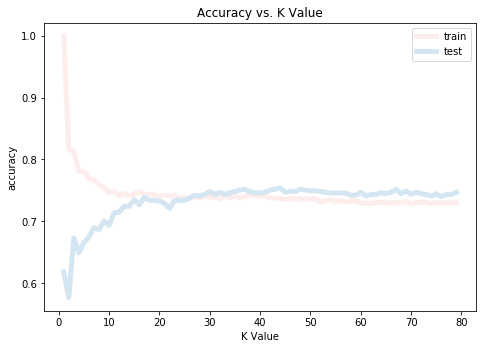

In [100]:
error_rate = []
accuracy_test = []
accuracy_train = []

ks = range(1, 80)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy_train, accuracy_test = make_predictions(knn, accuracy_train, accuracy_test)

plot_param_vs_acc(ks, accuracy_train, accuracy_test, 'K Value')

In [101]:
knn = KNeighborsClassifier(n_neighbors=43)
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)
y_pred_train = knn.predict(X_train)
print(confusion_matrix(y_test, y_pred_test))
print()
print('Precision: ', precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted'))
print('Recall: ', recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted'))
print()
print('Train Accuracy: ', accuracy_score(y_true=y_train, y_pred=y_pred_train))
print('Test Accuracy: ', accuracy_score(y_true=y_test, y_pred=y_pred_test))

[[108 161]
 [ 47 522]]

Precision:  0.7426072540037538
Recall:  0.7517899761336515

Train Accuracy:  0.7378321887130487
Test Accuracy:  0.7517899761336515


We can see that once again we got the result we were expecting and it's also very close to our decision tree.

####  <font color="D7BDE2"><b> 1.3: Logistic Regression </b></font>

Before we saw that with a LabelEncoder we can assign a value to each country, but we can't just do that in Logistic Regression since the bigger the value is the more biased the outcome will be towards that, meaning the country with the biggest label number gets the biggest score where their score should depend on the number of times that country appears and what happens to the target when it does, etc. Not it's label; the label is just a name. In this situation we use <font color="9AC0CD"><b>OneHot Encoding</b></font> which creates a new column for each country and in each row the country that used to be for that row gets the value 1, and the rest get 0. <br>

And again we scale the data for the same reasons we did in KNN.

In [102]:
X = clean_data.drop(columns=['Is Back'])  # Features
y = clean_data['Is Back']  # Target variable

In [103]:
lb = LabelBinarizer()
transformed = lb.fit_transform(X['Country'])
ohe_df = pd.DataFrame(transformed)
X_encoded = pd.concat([X, ohe_df], axis=1).drop(['Country'], axis=1)

X_encoded

,Total Quantity,Total Price,Purchase Count,Year,Month,Day,Day of Week,0,1,2,...,27,28,29,30,31,32,33,34,35,36
0,85,13.52,19,2011,10,31,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,298,15.90,33,2011,5,18,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,399,8.30,62,2011,10,16,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,27,11.90,16,2011,1,17,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,564,204.00,13,2010,12,12,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182,58,20.40,5,2011,3,20,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4183,582,5.04,62,2011,10,11,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4184,231,15.00,16,2011,7,25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4185,57,17.70,8,2011,5,26,3,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [104]:
scaler = StandardScaler()
scaler.fit(X_encoded)
scaled_features = scaler.fit_transform(X_encoded)
X_scaled = pd.DataFrame(scaled_features, columns=X_encoded.columns)
X_scaled.head()

,Total Quantity,Total Price,Purchase Count,Year,Month,Day,Day of Week,0,1,2,...,27,28,29,30,31,32,33,34,35,36
0,-0.377948,-0.036228,-0.226948,0.499477,0.765147,1.988744,-1.409191,-0.043753,-0.043753,-0.021861,...,-0.015456,-0.015456,-0.015456,-0.082051,-0.040922,-0.067517,-0.030923,-0.021861,-3.072686,-0.030923
1,0.099472,-0.034247,0.373487,0.499477,-0.496836,0.470925,-0.314112,-0.043753,-0.043753,-0.021861,...,-0.015456,-0.015456,-0.015456,-0.082051,-0.040922,-0.067517,-0.030923,-0.021861,0.325448,-0.030923
2,0.325854,-0.040573,1.617245,0.499477,0.765147,0.237415,1.876044,-0.043753,-0.043753,-0.021861,...,-0.015456,-0.015456,-0.015456,-0.082051,-0.040922,-0.067517,-0.030923,-0.021861,0.325448,-0.030923
3,-0.507949,-0.037577,-0.355613,0.499477,-1.506422,0.354170,-1.409191,-0.043753,-0.043753,-0.021861,...,-0.015456,-0.015456,-0.015456,-0.082051,-0.040922,-0.067517,-0.030923,-0.021861,0.325448,-0.030923
4,0.695686,0.122314,-0.484277,-2.002092,1.269940,-0.229607,1.876044,-0.043753,-0.043753,-0.021861,...,-0.015456,-0.015456,-0.015456,-0.082051,-0.040922,-0.067517,-0.030923,-0.021861,0.325448,-0.030923


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=101)

Here we take a different approach for hyperparameter tuning. To find the best combination of hyperparameters for a model we can use either <font color="9AC0CD"><b>GridSearchCV</b> or <b>RandomizedSearchCV</b></font>. The difference between these two is that Grid tries all the combinations but Random tries "n_iter" combinations randomly which makes it much faster and that's why it's the approach I chose to go with.

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [107]:
lr = LogisticRegression(random_state=101)
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, solver=solver)

# Create grid search using 5-fold cross validation
#clf = GridSearchCV(lr, hyperparameters, cv=5)
clf = RandomizedSearchCV(lr, hyperparameters, cv=5, n_iter=20) 
# Fit grid search
best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best Solver:', best_model.best_estimator_.get_params()['solver'])
    

c:\users\mahsa\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mahsa\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mahsa\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mahsa\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mahsa\appdata\local\pro

c:\users\mahsa\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mahsa\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mahsa\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mahsa\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\mahsa\appdata\local\pro

Best Penalty: l2
Best C: 2.7825594022071245
Best Solver: lbfgs


c:\users\mahsa\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [108]:
# Predict target vector
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

print(confusion_matrix(y_test, y_pred_test))
print()
print('Precision: ', precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted'))
print('Recall: ', recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted'))
print()
print('Train Accuracy: ', accuracy_score(y_true=y_train, y_pred=y_pred_train))
print('Test Accuracy: ', accuracy_score(y_true=y_test, y_pred=y_pred_test))

[[131 138]
 [ 78 491]]

Precision:  0.7312307965270569
Recall:  0.7422434367541766

Train Accuracy:  0.7396237682890415
Test Accuracy:  0.7422434367541766


Same thing:D

In [205]:
# split dataset in features and target variable
X = clean_data.drop(columns=['Is Back'])  # Features
y = clean_data['Is Back']  # Target variable

In [206]:
X['Country'] = le.fit_transform(X['Country'])

In [207]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
data_feat = pd.DataFrame(scaled_features, columns=X.columns)
#print(data_feat.head())
X_scaled = data_feat
X_scaled.head()

,Total Quantity,Total Price,Country,Purchase Count,Year,Month,Day,Day of Week
0,-0.524359,-0.044660,0.292425,-0.973192,-1.898812,1.238637,-1.392165,0.245448
1,-0.338777,-0.032135,-2.462283,-0.202732,0.526645,0.739386,2.011013,-1.407448
2,0.120864,-0.030117,0.292425,0.396514,0.526645,-0.508742,0.485450,-0.305517
3,0.338815,-0.036562,0.292425,1.637809,0.526645,0.739386,0.250748,1.898344
4,-0.463937,-0.033509,0.292425,-0.331142,0.526645,-1.507245,0.368099,-1.407448


In [208]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=101)

### <font color="9AC0CD"><b> Part 2: Ensemble Methods </b></font><br>

#### <font color="D7BDE2"><b> 2.1: Bagging </b></font>
<font color="73C6B6"><b>What are bagging and bootstrapping anyway? Why do they help us? </b></font><br>
Bagging, usually takes in weak learners, learns them independently from each other in parallel and combines them following some kind of deterministic averaging process very roughly, we can say that bagging will mainly focus at getting an ensemble model with <font color="9AC0CD"><b>less variance</b> </font>than its components whereas9AC0CD <font color="9AC0CD"><b>boosting and stacking</b></font> will mainly try to produce strong models <font color="9AC0CD"><b>less biased</b></font> than their components (even if variance can also be reduced). In parallel methods we fit the learners independently from each others and, so, it is possible to train them concurrently. The most famous such approach is “bagging” (standing for “bootstrap aggregating”) that aims at producing an ensemble model that is more robust than the individual models composing it. [3] While an individual tree is overfit to the training data and is likely to have large error, bagging (Bootstrap Aggregating) uses the insight that a suitably large number of uncorrelated errors average out to zero to solve this problem. Bagging chooses multiple random samples of observations from the training data, with replacement, constructing a tree from each one. Since each tree learns from different data, they are fairly uncorrelated from one another. [4]

In [113]:
from sklearn.ensemble import BaggingClassifier

In [114]:
bc_dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=45, random_state=101).fit(X_train, y_train)
y_pred_test = bc_dt.predict(X_test)
y_pred_train = bc_dt.predict(X_train)

print('Train Accuracy: ', accuracy_score(y_true=y_train, y_pred=y_pred_train))
print('Test Accuracy: ', accuracy_score(y_true=y_test, y_pred=y_pred_test))

Train Accuracy:  0.7396237682890415
Test Accuracy:  0.747016706443914


In [115]:
bc_knn = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=43), n_estimators=50, random_state=101).fit(X_train, y_train)
y_pred_test = bc_knn.predict(X_test)
y_pred_train = bc_knn.predict(X_train)

print('Train Accuracy: ', accuracy_score(y_true=y_train, y_pred=y_pred_train))
print('Test Accuracy: ', accuracy_score(y_true=y_test, y_pred=y_pred_test))

Train Accuracy:  0.7396237682890415
Test Accuracy:  0.747016706443914


#### <font color="D7BDE2"><b> 2.2: Random Forests </b></font>
<font color="73C6B6"><b>What is Random Forests? Why does it help? </b></font><br> 
Random Forest employs a number of techniques to <font color="9AC0CD"><b>reduce variance</b></font> in predictions while maintaining (to some extent) the low variance that was characteristic of the lone Decision Tree. It does this primarily by averaging together a number of very weakly correlated (if not completely uncorrelated) trees. Hyperparameters like <font color="9AC0CD"><b>max_features</b> and <b>min_samples_leaf</b></font> are among the techniques useful in reducing this correlation between trees, but they often come at the cost of some <font color="9AC0CD"><b>increase in bias</b></font>, since each tree now has less data to work with. [4]

In [211]:
from sklearn.ensemble import RandomForestClassifier

In [212]:
rfc = RandomForestClassifier(n_estimators=30, random_state=101, max_depth=5)
rfc.fit(X_train, y_train)
rfc_pred_test = rfc.predict(X_test)
rfc_pred_train = rfc.predict(X_train)

print('Train Accuracy: ', accuracy_score(y_true=y_train, y_pred=rfc_pred_train))
print('Test Accuracy: ', accuracy_score(y_true=y_test, y_pred=rfc_pred_test))

Train Accuracy:  0.7494272623138603
Test Accuracy:  0.7196796338672768


Just like we did before with Logistic Regression, We RandomSearchCV to tune RandomForests' hyperparameters. Then we build the model based on the results of hyperparameter tuning.

In [213]:
rfc = RandomForestClassifier(random_state=101)

n_estimators=range(10,80)
max_depth = range(1,20)
min_samples_leaf = range(1,10)
max_features = ['auto', 'sqrt', 'log2']
max_leaf_nodes = range(2,30)
# Create hyperparameter options
hyperparameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_features=max_features, n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes)

# Create grid search using 5-fold cross validation
#clf = GridSearchCV(lr, hyperparameters, cv=5)
clf = RandomizedSearchCV(rfc, hyperparameters, cv=5, n_iter=20) 
# Fit grid search
best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best  min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes'])


Best max_depth: 14
Best  min_samples_leaf: 6
Best max_features: sqrt
Best n_estimators: 39
Best max_leaf_nodes: 27


In [214]:
rfc = best_model
rfc.fit(X_train, y_train)
rfc_pred_test = rfc.predict(X_test)
rfc_pred_train = rfc.predict(X_train)

print('Train Accuracy: ', accuracy_score(y_true=y_train, y_pred=rfc_pred_train))
print('Test Accuracy: ', accuracy_score(y_true=y_test, y_pred=rfc_pred_test))

Train Accuracy:  0.7557273768613975
Test Accuracy:  0.7254004576659039


To get a visual perspective of what happens to overfits when we increase o reduce the hyperparameters, I've plotted, max_depth, n_estimators and max_leaf_nodes against accuracy of both train and test data.

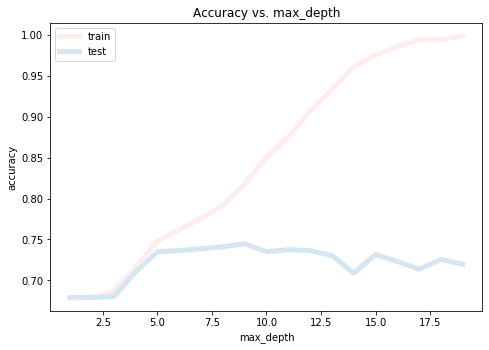

In [128]:
accuracy_test = []
accuracy_train = []

depths = range(1,20)

for depth in max_depth:

    rfc = RandomForestClassifier(max_depth=depth, random_state=101)
    accuracy_train, accuracy_test = make_predictions(rfc, accuracy_train, accuracy_test)

plot_param_vs_acc(depths, accuracy_train, accuracy_test, "max_depth")

as it is pretty clear when max_depth is higher than 5 it results in very high overfitting.

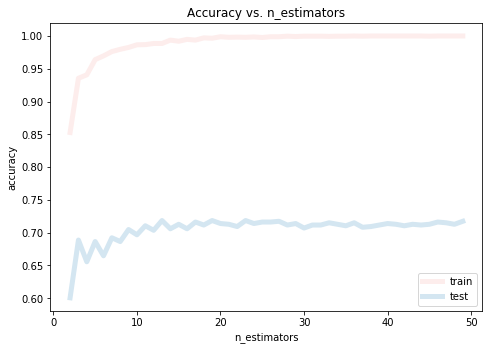

In [200]:
accuracy_test = []
accuracy_train = []

n_estimators = range(2,50)

for n in n_estimators:

    rfc = RandomForestClassifier(n_estimators=n, random_state=101)
    accuracy_train, accuracy_test = make_predictions(rfc, accuracy_train, accuracy_test)

plot_param_vs_acc(n_estimators, accuracy_train, accuracy_test, "n_estimators")

n_estimators always has a huge overfit but it's still after about 20.

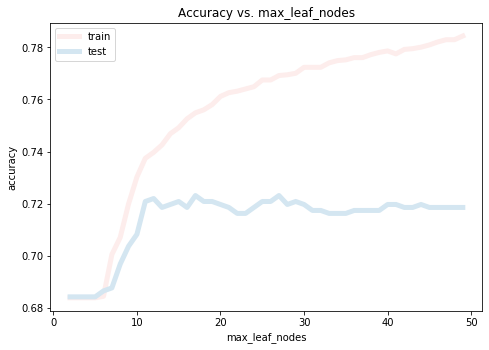

In [215]:
accuracy_test = []
accuracy_train = []

max_leaf_nodes=range(2,50)

for n in max_leaf_nodes:

    rfc = RandomForestClassifier(max_leaf_nodes=n, random_state=101)
    
    accuracy_train, accuracy_test = make_predictions(rfc, accuracy_train, accuracy_test)

plot_param_vs_acc(max_leaf_nodes, accuracy_train, accuracy_test, "max_leaf_nodes")

#### <font color="D7BDE2"><b> 2.3: Voting </b></font> 
What is the difference between Hard and Soft Voting? <br>

In Hard Voting: Classifier 1 predicts class A, Classifier 2 predicts class B, Classifier 3 predicts class C, ... <br>

But in Soft voting: Classifier 1 predicts class A with probability A%, Classifier 2 predicts class B with probability B%, Classifier 3 predicts class C with probability C%, ... <br>

Note that they can predict repetitive classes and the sum of percentages is not necessarily 100%.

In [122]:
from sklearn.ensemble import VotingClassifier

In [123]:
dt = DecisionTreeClassifier(max_depth=3)
knn = KNeighborsClassifier(n_neighbors=43)
lr = LogisticRegression()
vclf = VotingClassifier(estimators=[('decision tree', dt), ('k neighbors', knn), ('logistic regression', lr)])
vclf.fit(X_train, y_train)

y_pred_train = vclf.predict(X_train)
y_pred_test = vclf.predict(X_test)

print('Train Accuracy: ', accuracy_score(y_true=y_train, y_pred=y_pred_train))
print('Test Accuracy: ', accuracy_score(y_true=y_test, y_pred=y_pred_test))

Train Accuracy:  0.7411167512690355
Test Accuracy:  0.7577565632458234


### <font color="9AC0CD"><b> Conclusion</b></font>
We observed that Random Forests, Bagging, Voting are not really increasing our accuracy percentages, but why? All these three ensemble methods do some kind of voting between the lone classifiers we saw earlier in Part1 which had very similar outcomes. Ensemble methods sometimes cause the bias to increase like it was explained and seen in 2.2 Random Forests but the overfitting is always supposed to decrease.

### <font color="9AC0CD"><b> Refrences </b></font>
[1] https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html <br>
[2] https://medium.com/analytics-vidhya/why-is-scaling-required-in-knn-and-k-means-8129e4d88ed7 <br>
[3] https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205 <br>
[4] https://towardsdatascience.com/random-forests-and-the-bias-variance-tradeoff-3b77fee339b4 <br>
[5] https://towardsdatascience.com/hyperparameter-tuning-explained-d0ebb2ba1d35 <br>
[6] https://www.quora.com/Whats-the-difference-between-random-oversampling-and-oversampling-using-SMOTE-on-an-imbalanced-dataset-Is-the-later-always-better-then-the-first <br>
[7] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html <br>
